# **Aprendizaje Automático para Machine Learning**

##*Frameworks*##

###Andrea Azábal Lamoso###

21 de julio de 2021

---

# Preparación del entorno

Importamos los paquetes necesarios:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import re
import matplotlib.pyplot as plt

#CIFAR10

Para completar esta tarea, vamos a valernos del *dataset* CIFAR10 (*Canadian Institute For Advanced Research*), el cual contiene una recopilación de 60.000 imágenes a color de 10 categorías distintas (6.000 por clase). Las imágenes tienen una resolución de 32x32 píxeles, 3 canales de color y las categorías son las siguientes:

- 0: avión
- 1: coche
- 2: pájaro
- 3: gato
- 4: ciervo
- 5: perro 
- 6: rana
- 7: caballo
- 8: barco
- 9: camión

El objetivo es crear una red neuronal capaz de distinguir las 10 categorías y clasificarlas correctamente. En concreto, la red neuronal consistirá en: 

- Una capa para pasar las imágenes de 2D a 1D, con 32 x 32 x 3 nodos de entrada.
- Dos capas lineales con 128 y 64 nodos de salida, seguidas de una función de activación ReLU.
- Una capa lineal de salida (10 nodos) que obtenga la probabilidad de cada clase (SoftMax).

Además, como optimizador se seleccionará el método *Stochastic Gradient Descent (SGD)* y la función *cross entropy* como función de pérdida.

Con este objetivo en mente, vamos a proceder a trabajar con dos *frameworks* distintos: *TensorFlow* y *PyTorch*.

#*TensorFlow*

El primer *framework* que vamos a utilizar, *TensorFlow*, es una biblioteca de código abierto para aprendizaje automático desarrollada por Google para satisfacer sus necesidades de sistemas capaces de construir y entrenar redes neuronales para detectar y descifrar patrones y correlaciones.

Procedemos a importar las librerías que necesitaremos a lo largo del desarrollo:










In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers, losses, optimizers
from tensorflow.keras.utils import to_categorical

## *Dataset*

Comenzamos importando el *dataset* CIFAR10 y almacenando tanto el subconjunto de entrenamiento como el de *testing*, el cual posteriormente se utilizará para evaluar el modelo.





In [3]:
from tensorflow.keras import datasets
(x_train_tf, y_train_tf), (x_test_tf, y_test_tf) = datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


Comprobamos que el conjunto de datos consiste en 50.000 imágenes a color para el subconjunto de *training* y 10.000 para el de *test*, todas ellas de dimensión 32x32x3 (3 canales RGB):

In [ ]:
print('Train: X=%s, y=%s' % (x_train_tf.shape, y_train_tf.shape))
print('Test: X=%s, y=%s' % (x_test_tf.shape, y_test_tf.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


Además, también podemos asegurarnos de que cada clase contiene el mismo número de instancias:

In [11]:
np.unique(y_train_tf, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

Es decir, se tiene un *dataset* balanceado, lo cual facilitará la evaluación del modelo.

Por otra parte, podemos representar un ejemplo de imagen para cada una de las 10 categorías:

In [ ]:
class_names = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
               5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
y_u_tf=pd.DataFrame(y_train_tf).drop_duplicates()
X_u_tf=x_train_tf[y_u_tf[0].sort_values().index]

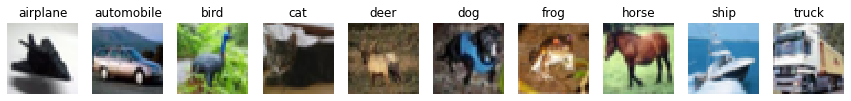

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 15))
for ax, image, label in zip(axes, X_u_tf, y_u_tf[0].sort_values().map(class_names)):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(label)

Por último, antes de comenzar con la modelización, normalizamos las imágenes. Todas ellas contienen valores entre 0 y 255 en función de la intensidad de cada píxel, por lo que dividimos todos los datos entre la cantidad máxima:

In [ ]:
x_train_tf, x_test_tf = x_train_tf / 255.0, x_test_tf / 255.0

Además, al tratarse de un *dataset* multiclase, las etiquetas están en una sola columna, mientras que la salida de la red neuronal será multicolumna (10 nodos en total). Por tanto, nos valemos de la función `to_categorical` de *tensorflow.keras.utils* para convertirla en nuevas columnas que contengan valores binarios (*One-Hot Encoding*):

In [ ]:
y_train_tf = to_categorical(y_train_tf)
y_test_tf = to_categorical(y_test_tf)

##Modelo

Una vez está listo el *dataset*, procedemos a configurar las capas del modelo. Estas capas son los bloques básicos de una red neuronal y se encargan de extraer información de los datos disponibles. En una red neuronal, se encadenan varias capas simples que posteriormente son entrenadas con el objetivo de aprender a clasificar los datos de entrada.


En concreto, en nuestro modelo vamos a incluir en primer lugar una capa (`tf.keras.layers.Flatten`) que transforma el formato de las imágenes de un *array* de dimensiones 32x32x3 a un *array* unidimensional (3072 píxeles). Así, en esta capa no se está optimizando ningún parámetro ni realizando ningún tipo de aprendizaje, sino que simplemente estamos modificando los datos de entrada. 

Tras "aplanar" los píxeles, la red consistirá en una secuencia de tres capas `tf.keras.layers.Dense`, la primera de ellas con 128 nodos, la segunda con 64 y la última con tantos nodos como categorías vamos a clasificar, es decir, 10 en total. Esta última capa devuelve una puntuación para cada nodo, la cual puede interpretarse como la probabilidad de que la imagen pertenezca a cada una de las categorías.

En cada capa, además, se especifica la función de activación que se va a aplicar. En nuestro caso, aplicamos la función Rectified Linear Units (ReLU) en las capas intermedias y Softmax en la última.

A continuación puede verse un resumen de la red que hemos modelizado. En la tabla puede observarse el número de parámetros que deben entrenarse en cada una de las capas (más de 400.000 en total):


In [ ]:
tf.keras.backend.clear_session() # reiniciar

In [ ]:
model_tf = models.Sequential()
model_tf.add(layers.Flatten(input_shape=(32, 32, 3))) # dimensión del dataset de entrada
model_tf.add(layers.Dense(128, activation="relu"))
model_tf.add(layers.Dense(64, activation="relu"))
model_tf.add(layers.Dense(10, activation="softmax")) # 10 categorías

model_tf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 402,250
Trainable params: 402,250
Non-trainable params: 0
_________________________________________________________________


##Compilar el modelo

Antes de que el modelo esté listo para entrenarlo, se necesita ajustar algunos parámetros más:

- Función de pérdida o *loss function*: mide cómo de preciso es el modelo durante el entrenamiento y es necesario minimizarla para que el modelo mejore su capacidad de predicción. En este caso, al haber 10 categorías distintas, utilizamos la función `categorical_crossentropy`.

- Optimizador: consiste en el método para actualizar los pesos del modelo basándose en la función de pérdida. En este caso seleccionamos *Stochastic Gradient Descent* (SGD).

- Métricas: se utilizan para monitorizar el entrenamiento y el *testing*. Las más habituales son la precisión (*accuracy*), la cual indica el porcentaje de imágenes clasificadas correctamente, y el error cuadrático medio (*mse*).

In [ ]:
model_tf.compile(
    optimizer="SGD",
    loss="categorical_crossentropy",
    metrics=["mse", "accuracy"]
)

##Entrenamiento del modelo

Una vez se ha terminado de especificar el modelo, es hora de entrenarlo mediante el método `model_tf.fit()` aplicándolo al subconjunto de entrenamiento. Así, se especifican los parámetros:

- `epochs`: número de iteraciones completas sobre todo el subconjunto de entrenamiento. Seleccionamos 50 iteraciones.

-  `batch_size`: divide el *set* de datos en *batches* del tamaño especificado, seleccionamos 16 imágenes por cada *batch*. 

- `validation_split`: conjunto de datos de prueba (20% del total) que utilizará para computar las métricas al finalizar cada `epoch`.




In [ ]:
history = model_tf.fit(
    x_train_tf, y_train_tf,
    epochs=50,
    batch_size=16,
    #validation_data = (x_test_tf, y_test_tf)
    validation_split=0.2
)

Epoch 1/50
2500/2500 [==============================] - 10s 3ms/step - loss: 1.8926 - mse: 0.0799 - accuracy: 0.3150 - val_loss: 1.7703 - val_mse: 0.0761 - val_accuracy: 0.3708
Epoch 2/50
2500/2500 [==============================] - 6s 2ms/step - loss: 1.7074 - mse: 0.0743 - accuracy: 0.3898 - val_loss: 1.7540 - val_mse: 0.0755 - val_accuracy: 0.3787
Epoch 3/50
2500/2500 [==============================] - 6s 3ms/step - loss: 1.6280 - mse: 0.0715 - accuracy: 0.4213 - val_loss: 1.6020 - val_mse: 0.0705 - val_accuracy: 0.4352
Epoch 4/50
2500/2500 [==============================] - 6s 3ms/step - loss: 1.5707 - mse: 0.0696 - accuracy: 0.4410 - val_loss: 1.6185 - val_mse: 0.0712 - val_accuracy: 0.4285
Epoch 5/50
2500/2500 [==============================] - 6s 2ms/step - loss: 1.5319 - mse: 0.0683 - accuracy: 0.4560 - val_loss: 1.5719 - val_mse: 0.0691 - val_accuracy: 0.4506
Epoch 6/50
2500/2500 [==============================] - 6s 2ms/step - loss: 1.4978 - mse: 0.0670 - accuracy: 0.4683 - v

En cada iteración, se muestran los valores de la función de pérdida (*loss*), el error cuadrático medio (*mse*) y la precisión (*accuracy*) tanto para el subconjunto de entrenamiento como para el de evaluación.

En general, se ve cómo, según la red neuronal va aprendiendo (al avanzar las *epochs*), tanto el error como la función de pérdida disminuyen para el subconjunto de entrenamiento, lo cual se traduce en un aumento de la precisión. 

Para el subconjunto de *test*, sin embargo, la disminución no es monótona y se observa una cierta oscilación en los valores de la pérdida. Esto se debe a que, a partir de cierto número de iteraciones, estamos sobreajustando el modelo al conjunto de entrenamiento y la red tiene problemas a la hora de generalizar la clasificación a otros conjuntos de datos. Es decir, se observa *overfitting*.

##Evaluación del modelo

- **Función de pérdida**

Si representamos gráficamente los resultados para la *loss function* obtenidos durante el entrenamiento y la validación del modelo, obtenemos la siguiente gráfica:

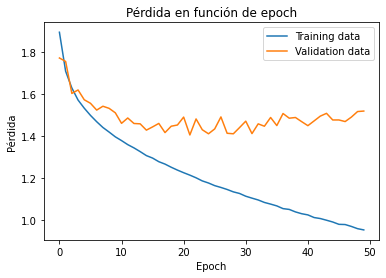

In [ ]:
plt.plot(history.history['loss'], label='Training data')
plt.plot(history.history['val_loss'], label='Validation data')
plt.title('Pérdida en función de epoch')
plt.xlabel('Epoch')
plt.ylabel('Pérdida')
plt.legend()

Aquí se ve cómo la evolución es monótona decreciente para el subconjunto de entrenamiento, mientas que oscila mucho para el subconjunto de *test*. Como ya hemos argumentado, es un síntoma de que tenemos un sobreajuste de la red a los datos de entrenamiento.

- **Precisión**

De manera análoga, procedemos a representar la precisión en función del número de iteraciones:

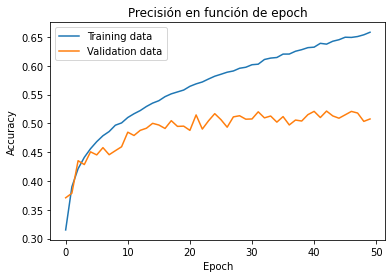

In [ ]:
plt.plot(history.history['accuracy'], label='Training data')
plt.plot(history.history['val_accuracy'], label='Validation data')

plt.title('Precisión en función de epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

La precisión sobre el subconjunto de entrenamiento es ligeramente inferior a la precisión sobre el subconjunto de *test* para un número de iteraciones bajas, mientras que a partir de aproximadamente 10 *epochs* la tendencia se invierte. Esto es debido a que, para pocas iteraciones sobre el subconjunto de entrenamiento, los parámetros del modelo no están lo suficientemente optimizados y existe *underfitting*. Es decir, el modelo todavía no ha aprendido a clasificar las imágenes. Como la precisión sobre el *dataset* de evaluación se calcula tras entrenar el modelo sobre todo el *dataset* de entrenamiento, tiene sentido que si los parámetros no están muy optimizados la *accuracy* sea mejor al haber completado una *epoch* entera.

A medida que aumenta el número de *epochs*, la precisión sobre el subconjunto de *training* supera a la de *test*. Si seguimos entrenando el modelo, vemos cómo la precisión de *training* sigue aumentando mientras que la de *test* comienza a oscilar en torno a un valor, es decir, se estanca.  A partir de ese punto, estaríamos teniendo *overfitting*, por lo que no sería necesario seguir entrenando el modelo sobre más *epochs*, ya que lo estaríamos sobreajustando al subconjunto de entrenamiento y podría perder capacidad de generalización al aplicarlo sobre nuevos *datasets*. 

En este caso en concreto, el comportamiento para el set de evaluación es oscilatorio y no parece mejorar significativamente para más de aproximadamente 20 iteraciones. 

Finalmente, una vez entrenado el modelo completo, procedemos a calcular la precisión final sobre el *dataset* de prueba de 10.000 imágenes que habíamos generado al comienzo de la actividad. Así:

In [ ]:
train_loss, train_mse, train_acc = model_tf.evaluate(x_train_tf, y_train_tf, verbose=2)
test_loss, test_mse, test_acc = model_tf.evaluate(x_test_tf, y_test_tf, verbose=2)
print('\nTrain accuracy:', round(train_acc,2))
print('\nTest accuracy:', round(test_acc,2))

1563/1563 - 3s - loss: 1.0300 - mse: 0.0479 - accuracy: 0.6416
313/313 - 1s - loss: 1.4823 - mse: 0.0645 - accuracy: 0.5108

Train accuracy: 0.64

Test accuracy: 0.51


Vemos que la precisión final sobre el subconjunto de entrenamiento es de 64% mientras que para el subconjunto de prueba es bastante inferior, del 51%. Esto es debido a que el algoritmo se ajusta mejor a los datos de entrenamiento (debido al gran número de iteraciones realizadas en el entrenamiento) y no es tan bueno generalizando sobre nuevos datos como los del subconjunto de *test*.

- **Matriz de confusión**

Si queremos averiguar cómo se está clasificando cada una de las clases, podemos representar la matriz de confusión del modelo:

In [ ]:
pred_tf = model_tf.predict(x_test_tf)
pred_tf = np.argmax(pred_tf, axis = 1)
labels = np.argmax(y_test_tf, axis = 1)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
matriz=confusion_matrix(labels,pred_tf)

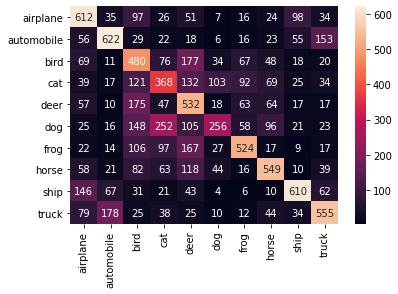

In [ ]:
sn.heatmap(pd.DataFrame(matriz),
           annot=True,fmt='g',xticklabels=class_names.values(),yticklabels=class_names.values())

En la matriz podemos apreciar que hay clases que se están clasificando mucho mejor que otras. Si nos fijamos en la categoría *airplane*, por ejemplo, vemos que la mayoría de imágenes que contienen aviones se están clasificando correctamente, es decir, el *recall* para esta categoría es bastante alto pues no se tiene un gran número de falsos negativos. Además, de las veces que el algoritmo ha clasificado una imagen como *airplane*, la mayoría han sido correctas, aunque es cierto que un número significativo de estas imágenes en realidad contenían barcos (*ship*).

- ***Classification report***

Para analizar más fácilmente el desempeño de cada categoría, mostramos el *classification report*:

In [ ]:
print(f"Informe de Clasificación:\n"
      f"{classification_report(labels, pred_tf, target_names=class_names.values())}")

Informe de Clasificación:
              precision    recall  f1-score   support

    airplane       0.53      0.61      0.57      1000
  automobile       0.63      0.62      0.62      1000
        bird       0.37      0.48      0.42      1000
         cat       0.36      0.37      0.37      1000
        deer       0.39      0.53      0.45      1000
         dog       0.50      0.26      0.34      1000
        frog       0.60      0.52      0.56      1000
       horse       0.58      0.55      0.56      1000
        ship       0.68      0.61      0.64      1000
       truck       0.58      0.56      0.57      1000

    accuracy                           0.51     10000
   macro avg       0.52      0.51      0.51     10000
weighted avg       0.52      0.51      0.51     10000



La columna *F1-Score* tiene en cuenta tanto la *precision* como el *recall* de cada categoría. A mayor valor, mejor se están clasificando las imágenes por categoría.

En este caso, vemos que las clases que mejor clasifica el algoritmo son *ship* y *automobile*. Por el contrario, la red neuronal tiene problemas con las imágenes que contienen perros y gatos. En la matriz de confusión podemos ver que las imágenes de perros han sido clasificadas 256 veces correctamente, mientras que 252 veces como "gato". De manera similar, de las veces que se ha catalogado "gato", un gran número de imágenes contenían realmente un perro. Es decir, el modelo tiene problemas a la hora de distinguir entre estas dos clases. Además, los gatos también se clasifican  bastantes veces como "pájaro" o "ciervo".

#*Pytorch*

El segundo *framework* que vamos a utilizar para la implementación de una red neuronal artificial es *PyTorch​*: una biblioteca de aprendizaje automático ​de código abierto basada en la biblioteca de Torch, principalmente desarrollada por el Laboratorio de Investigación de Inteligencia Artificial​ de Facebook (FAIR).

Así, en primer lugar importamos las librerías necesarias para el desarrollo:

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch.optim as optim

##*Dataset*

Vamos a utilizar de nuevo el mismo conjunto de datos, CIFAR10, pero en este caso desde la librería de *PyTorch*. 

Así, es necesario convertir las imágenes del conjunto de datos en tensores mediante la aplicación de las funciones `transforms.ToTensor()` y `transforms.Normalize()`, la cual da como resultado tensores normalizados. 

Una vez hemos definido la función de transformación, descargamos el subconjunto de entrenamiento (`train=True`) y el de prueba (`train=False`).

Además, como vamos a trabajar con un amplio número de parámetros, es conveniente cargar los datos en *batches* mediante `torch.utils.data.DataLoader()`, gracias a la cual estaremos dividiendo el conjunto original en subconjuntos de 16 imágenes cada uno. Por último, seleccionamos `shuffle=True` con el fin de desordenar las filas del conjunto de datos de entrenamiento (para el de *test* no es necesario).

In [ ]:
from torchvision import datasets

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

torch.manual_seed(80)
# obtenemos el trainset con el parámetro train=True
trainset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=transform)
# para aleatorizar el trainset => shuffle=True
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

# obtenemos el testset con el parámetro train=False
testset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=False, transform=transform)
# no se necesita agitar el testset => shuffle=False
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False)


Extracting /root/.pytorch/CIFAR10_data/cifar-10-python.tar.gz to /root/.pytorch/CIFAR10_data/
Files already downloaded and verified


Una vez hemos cargado los *datasets*, podemos representar una muestra de las imágenes con sus categorías correspondientes:

images.shape: torch.Size([16, 3, 32, 32])
 ship  plane    car   bird   frog    car   deer  truck  plane   bird    dog    cat    cat   deer    dog    cat


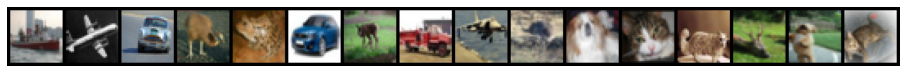

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

from torchvision.utils import make_grid
for images, labels in trainloader:
    images = images / 2 + 0.5 #deshacer normalizacion
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    print('  '.join('%5s' % classes[labels[i]] for i in range(16)))
    break

##Modelo

Siguiendo los mismos pasos que en el *framework* anterior, es hora de generar el modelo de la red neuronal. En este caso nos valemos de la clase `nn.Sequential()`, dentro de la cual se definirán las distintas capas (secuenciales) y sus correspondientes nodos.

Para ello, en primer lugar es necesario "aplanar" las imágenes de entrada. Si recordamos el modelizado previo, tenemos imágenes de dimensión 32x32x3 que pasarán a una única dimensión de longitud 3072 píxeles. Por tanto, la primera capa de la red se encargará de realizar esta transformación `nn.Flatten()`.

En la siguiente capa, la primera capa `nn.Linear()`, se tiene una dimensión de entrada de 3072 y una de salida de 128. A continuación se añaden otras dos capas del mismo tipo, una con salida 64 y la otra con salida 10. La razón es que la última capa debe tener tantos nodos de salida como categorías pueden ser clasificadas por la red neuronal.

Es en las capas intermedias en las que se realiza el aprendizaje, siendo la salida de la última capa la que establecerá la predicción final. Además, es importante seleccionar las funciones de activación que se utilizan en las capas intermedias, habiendo elegido en nuestro caso *Rectified Linear Units* (ReLU). En la última capa, el resultado se determinará tras aplicar la función *LogSoftmax*.

In [ ]:
model_pt = nn.Sequential(nn.Flatten(),
    nn.Linear(32*32*3,128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,10),
    nn.LogSoftmax(dim=1))

print(model_pt)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
  (6): LogSoftmax(dim=1)
)


A continuación, al igual que para el *framework* *TensorFlow*, definimos la *loss function* o función de pérdida (`criterion`) con el método `nn.CrossEntropyLoss()`.

El optimizador utilizará el método *Stochastic Gradient Descent* (SGD) con un `learning_rate = 0.001`, y se encargará de actualizar los parámetros del modelo `model.parameters()`.

In [ ]:
optimizer = optim.SGD(model_pt.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

##Entrenamiento del modelo

Con el objetivo de entrenar el modelo sobre el subconjunto de entrenamiento, vamos a crear un bucle *for* el cual iterará un total de 50 *epochs*. 

Dentro de este bucle, en primer lugar se recorrerá el *dataset* de entrenamiento (por *batches*). En cada iteración se realizarán los siguientes pasos:

1. Inicializar los gradientes de los parámetros.
2. Ejecutar el método *forward*.
3. Calular la función de pérdida.
4. Ejecutar el método *backward*.
5. Actualizar los pesos del modelo aplicando los gradientes a los parámetros.

Además, se almacenarán los resultados de las predicciones sobre cada *batch* (valor máximo de las probabilidades devueltas por las 10 últimas neuronas), de manera que podamos ver cómo evoluciona la precisión en cada *batch* y en cada *epoch*.


Mientras se entrena el modelo, vamos a ir aplicándolo sobre el *dataset* de prueba para posteriormente evaluar cómo se comporta. El código implementado será similar, iterando esta vez sobre *batches* del subconjunto de *testing*, ejecutando el método *forward*, hallando la clase más probable en la predicción y almacenando la pérdida y la precisión para cada *epoch*.


In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        m.reset_parameters()


#model_pt.apply(init_weights) #en caso de volver a ejecutar el entrenamiento

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=3072, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
  (6): LogSoftmax(dim=1)
)

A continuación, entrenamos el algoritmo durante 50 *epochs*:

In [ ]:
import time
start_time = time.time()

epochs = 50

# Inicializo listas
train_loss = []
train_correct = []
test_loss = []
test_correct  = []


for e in range(epochs):
    model_pt.train()

    #Inicializo variables
    trn_corr = 0
    tst_corr = 0
    batch_corr = 0
    trn_loss = 0
    tst_loss = 0
    
    ###TRAIN
    for batch, (x_train, y_train) in enumerate(trainloader):
      batch +=1 # empieza en 0

      #ENTRENAMIENTO
      optimizer.zero_grad() # inicializa los gradientes de los parámetros
      logits = model_pt(x_train) # ejecuta el método forward 
      loss = criterion(logits, y_train) # calcula la pérdida
      loss.backward() # calcula los gradientes a partir de la pérdida
      optimizer.step()  # actualiza los pesos del modelo aplicando los gradientes a los parámetros 
      
      #PREDICCION
      predicted = torch.max(logits.data, 1)[1] # clase con probabilidad máxima
      batch_corr = (predicted == y_train).sum() # sumo predicciones correctas en el batch

      #MÉTRICAS
      trn_corr += batch_corr # acumulo predicciones correctas
      trn_loss += loss.item()

      if batch % 1000 == 0: # hago print cada 1000 batch   
        accuracy = trn_corr.item()*100 / (batch*16)        
        print( f'epoch: {e} batch {batch} loss:{loss.item()} accuracy:{accuracy} ')
        #print( f'epoch: {e} batch {batch} trn_corr:{trn_corr} batch:{batch*16} ')
    
    train_loss.append(trn_loss/batch) # añado la pérdida en cada epoch
    train_correct.append(trn_corr) # añado total correctas en cada epoch


    ###EVAL
    with torch.no_grad():
      model_pt.eval()

      for batch, (x_test, y_test) in enumerate(testloader):
        batch +=1
        #Prediccion
        y_val = model_pt(x_test) # ejecuta el método forward     
        predicted = torch.max(y_val.data, 1)[1] # clase con probabilidad máxima
        tst_corr += (predicted == y_test).sum() # sumo predicciones correctas
        #Perdida
        loss = criterion(y_val,y_test)
        tst_loss += loss.item()

    test_loss.append(tst_loss/batch)
    test_correct.append(tst_corr)

total_time = time.time() - start_time
print( f' Duration: {total_time/60} mins')

epoch: 0 batch 1000 loss:2.2538938522338867 accuracy:15.2625 
epoch: 0 batch 2000 loss:2.2558319568634033 accuracy:19.334375 
epoch: 0 batch 3000 loss:2.2770206928253174 accuracy:21.0 
epoch: 1 batch 1000 loss:2.0742735862731934 accuracy:27.675 
epoch: 1 batch 2000 loss:1.9689489603042603 accuracy:28.296875 
epoch: 1 batch 3000 loss:1.97250497341156 accuracy:29.252083333333335 
epoch: 2 batch 1000 loss:1.846496343612671 accuracy:31.90625 
epoch: 2 batch 2000 loss:1.848829984664917 accuracy:33.2 
epoch: 2 batch 3000 loss:1.5601086616516113 accuracy:33.71041666666667 
epoch: 3 batch 1000 loss:1.8140391111373901 accuracy:36.7125 
epoch: 3 batch 2000 loss:1.9052385091781616 accuracy:36.671875 
epoch: 3 batch 3000 loss:1.8100979328155518 accuracy:36.92916666666667 
epoch: 4 batch 1000 loss:1.5474684238433838 accuracy:38.9 
epoch: 4 batch 2000 loss:1.4348113536834717 accuracy:38.70625 
epoch: 4 batch 3000 loss:1.593384861946106 accuracy:39.03125 
epoch: 5 batch 1000 loss:1.81174635887146 acc

En la ejecución podemos observar cómo la precisión sobre el subconjunto de entrenamiento va aumentando en cada iteración, mientras que la función de pérdida tiene una tendencia generalmente descendente. Cabía esperar estos resultados, pues con cada iteración la matriz de pesos del modelo se está ajustando de manera que el algoritmo vaya aprendiendo a clasificar cada vez mejor el conjunto de datos.

## Evaluación

Ahora que el modelo está entrenado, podemos representar gráficamente el resultado del proceso iterativo sobre cada subconjunto de datos. Tanto la *accuracy* representada como los valores para la pérdida se han promediado sobre todos los *batches* de cada *epoch*.

Si representamos la función de pérdida o *loss function* en relación a las *epoch*:


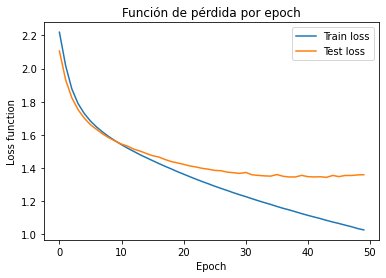

In [ ]:
loss_total_train = np.asarray(train_loss)
loss_total_test = np.asarray(test_loss)
plt.title('Función de pérdida por epoch')
plt.plot(loss_total_train, label= "Train loss")
plt.plot(loss_total_test, label= "Test loss")
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend()

Vemos que, para un número de *epochs* inferior a 10, el valor de la función de pérdida es mayor para el *train* que para el *test*, al igual que ocurría en el *framework Tensorflow*.

Además, se confirma la tendencia monótona descendente según van avanzando las iteraciones sobre el subconjuto de *training*, es decir, el optimizador está cumpliendo correctamente su función y avanzando hacia el mínimo de la *loss function*. El descenso para el subconjunto de prueba, en cambio, se hace cada vez más suave hasta alcanzar un *plateau* a partir de aproximadamente **30 iteraciones.** A partir de este punto, podemos considerar que existe *overfitting* y, si seguimos entrenando el modelo, tendremos un resultado contraproducente pues se ajustará en exceso al conjunto de datos de entrenamiento y no mejorará la clasificación sobre nuevos *datasets*.



Si procedemos a representar la precisión, es decir, el número de imágenes acertadas entre el total:

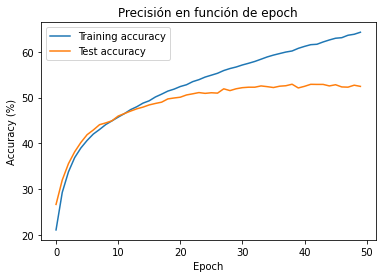

In [ ]:
accuracy_total_train = np.asarray(train_correct)/50000.0
accuracy_total_test = np.asarray(test_correct)/10000.0
plt.plot(accuracy_total_train*100, label= "Training accuracy")
plt.plot(accuracy_total_test*100, label= "Test accuracy")
plt.title('Precisión en función de epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

Comprobamos que, para el subconjunto de entrenamiento, hay un comportamiento monótonamente ascendente según aumenta el número de iteraciones mientras que el *dataset* de *testing* alcanza un *plateau* en torno al 50% de precisión. 

Además, para un número bajo de iteraciones, vemos cómo la precisión sobre el subconjunto de *test* es inferior a la precisión sobre el subconjunto de entrenamiento. La causa es que para tan pocas *epoch*, los parámetros del modelo no están suficientemente optimizados y la red no se ajusta lo suficiente a los datos. Es decir, existe *underfitting*. La razón es que la precisión se está promediando sobre toda una *epoch*, mientras que la evaluación ocurre una vez finalizado el entrenamiento para dicha iteración, por lo que los parámetros están mejor ajustados al llegar a la parte de evaluación y la mejora en la clasificación es significativa para *epochs* lo suficientemente tempranas.

A partir de un cierto número de iteraciones, aproximadamente 10, la tendencia se invierte y vemos cómo la precisión del subconjunto de *training* supera a la de *test*. Si seguimos entrenando,  vemos cómo la precisión de *training* sigue aumentando mientras que la de *test* llega a un *plateau*. Ese será el punto en el que comencemos a tener *overfitting* o sobreajuste a los datos de entrenamiento, por lo que no tendrá sentido seguir entrenando el modelo durante más *epochs*. Si siguiéramos entrenando para más *epochs*, es probable que observáramos cómo se pierde capacidad de clasificación sobre nuevos *datasets* debido al sobreajuste para el *dataset* de entrenamiento.

En resumen, basta con entrenar el modelo durante unas 30 iteraciones aproximadamente, pues la precisión sobre el subconjunto de evaluación no supera el 50% aunque sigamos con el entrenamiento. Si nos fijamos, este resultado para la precisión es el mismo que obtuvimos con el *framework* *TensorFlow*.

#Conclusiones

A lo largo de esta tarea, se ha entrenado la misma red neuronal bajo dos *frameworks* diferentes y se ha evaluado su rendimiento sobre un subconjunto de *testing* de 10.000 imágenes, para el cual se ha visto la evolución de la función de pérdida y la precisión global en función del número de iteraciones sobre el *dataset* completo (*epochs*).

A continuación, procedemos a realizar una comparación sobre los resultados en ambos *frameworks*:

- *Loss function*:

Si comparamos la evolución durante el entrenamiento de la función de pérdida en ambos *datasets* para ambos *frameworks*:





    

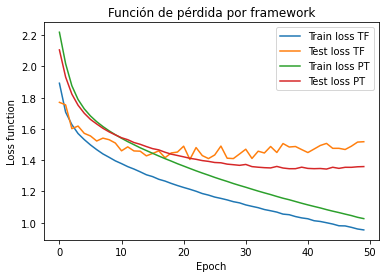

In [ ]:
plt.title('Función de pérdida por framework')
plt.plot(history.history['loss'], label='Train loss TF')
plt.plot(history.history['val_loss'], label='Test loss TF')
plt.plot(loss_total_train, label= "Train loss PT")
plt.plot(loss_total_test, label= "Test loss PT")
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend()

Vemos que las tendencias son similares en ambos *frameworks*, pues la función de pérdida del subconjunto de entrenamiento tiende a disminuir monótonamente con el número de iteraciones, mientras que la función de pérdida sobre el subconjunto de prueba tiende a estancarse a partir de 20-30 *epochs*. 


- Precisión global:

Si representamos la *accuracy* para cada *framework* obtenemos:

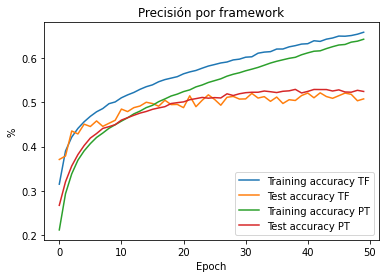

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy TF')
plt.plot(history.history['val_accuracy'], label='Test accuracy TF')
plt.plot(accuracy_total_train, label= "Training accuracy PT")
plt.plot(accuracy_total_test, label= "Test accuracy PT")
plt.title('Precisión por framework')
plt.xlabel('Epoch')
plt.ylabel('%')
#plt.ylim([0.2,0.55])
plt.legend()

En general, se observa que en ambos *framework* se sigue la misma tendencia, aumentando las precisiones del subconjunto de *training* según avanza el entrenamiento, mientras que las del subconjunto de *test* se estancan en torno a un 50% a partir de unas 30 iteraciones aproximadamente. Las pequeñas discrepancias entre ambos entornos pueden deberse a diferencias en el preprocesado de datos, en la inicialización de los parámetros de la red o en los cálculos de las métricas, por ejemplo.

Por tanto, se concluye que con una red neuronal de estas características, la precisión que conseguimos obtener es aproximadamente del 50%, es decir, se clasifica correctamente la mitad de las imágenes. Este resultado no es tan malo teniendo en cuenta que se trata de una red muy simple de tan solo tres capas lineales, si bien es cierto que para algunas clases los resultados son muy pobres (*cat* y *dog*).

Para mejorar los resultados obtenidos, podríamos convertir nuestra red en una red neuronal convolucional (CNN) en la cual incluiríamos capas convolucionales junto con *Dropout* antes del bloque clasificador, con el objetivo de extraer las características más relevantes de cada imagen y así mejorar las predicciones y reducir el *overfitting*.